In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from shark.utils import nb_init

nb_init()

INFO | nb_init | Set current dir to chess
INFO | nb_init | You are using Python 3.10.10 (main, Sep 14 2023, 16:59:47) [Clang 14.0.3 (clang-1403.0.22.14.1)]


# PPO againt on Inverted Double Pendulum

In [9]:
from loguru import logger
import os
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
import pandas as pd

from shark.env import ChessEnv
from shark.models import PPOChess
from shark.utils import get_logged_metrics_from_trainer

engine_executable = os.environ.get("CHESS_ENGINE_EXECUTABLE", "stockfish")

## Create model

We choose the gymnasium environment here.

In [10]:
frame_skip = 1
frames_per_batch = frame_skip * 100
model = PPOChess(
    env=ChessEnv(engine_executable),
    frame_skip=frame_skip,
    frames_per_batch=frames_per_batch,
)

## Training

In order to train the model, run the following cell.

In [11]:
# Training
trainer = pl.Trainer(
    accelerator="cpu",
    max_steps=2000,
    val_check_interval=100,
    log_every_n_steps=1,
    logger=CSVLogger(
        save_dir="lightning_logs",
        name=model.__class__.__name__,
    ),
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(model)

Missing logger folder: lightning_logs/PPOChess

  | Name             | Type               | Params
--------------------------------------------------------
0 | base_env         | ChessEnv           | 0     
1 | env              | TransformedEnv     | 0     
2 | actor_net        | Sequential         | 2.4 M 
3 | policy_module    | ProbabilisticActor | 2.4 M 
4 | value_net        | MLP                | 345 K 
5 | value_module     | ValueOperator      | 345 K 
6 | advantage_module | GAE                | 0     
7 | loss_module      | ClipPPOLoss        | 2.8 M 
--------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.049    Total estimated model params size (MB)


In [ ]:
# Get logged stuff
df = get_logged_metrics_from_trainer(trainer)

INFO | <module> | pytest_artifacts/PPO/version_5
INFO | <module> | {'loss/train': tensor(21.0359), 'reward/train': tensor(9.3014), 'step_count/train': tensor(40.), 'reward/eval': tensor(9.3076), 'reward_sum/eval': tensor(381.6126), 'step_count/eval': tensor(40.)}
INFO | <module> |    step_count/train  step_count/eval  reward/train  step  epoch  reward/eval  \
0               9.0              7.0      9.096684     0      0     9.113627   
1               9.0              7.0      9.111898     1      0     9.113627   
2              15.0              7.0      9.129646     2      0     9.113627   
3              13.0              7.0      9.138023     3      0     9.113627   
4              10.0              7.0      9.107519     4      0     9.113627   

   loss/train  reward_sum/eval  
0   31.317650        72.909019  
1   33.172077        72.909019  
2   39.270416        72.909019  
3   32.026806        72.909019  
4   32.270885        72.909019  


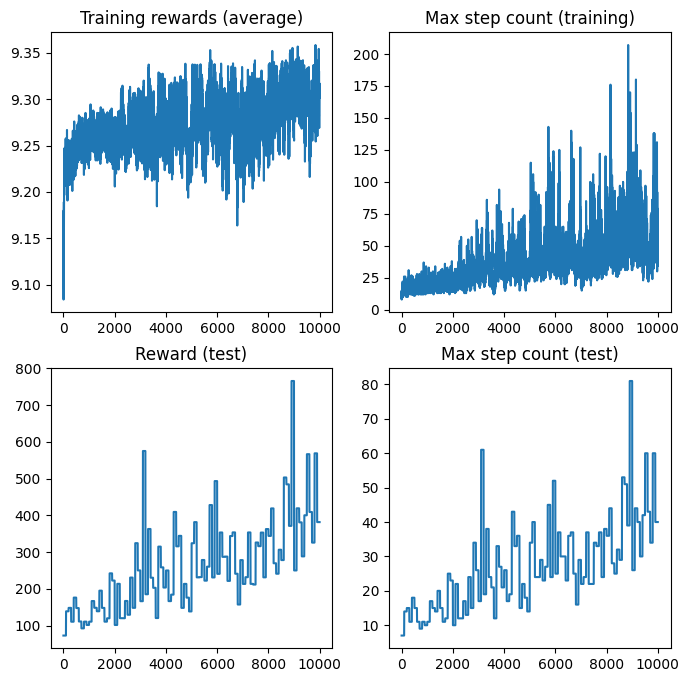

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(df["reward/train"].to_numpy())
plt.title("Training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(df["step_count/train"].to_numpy())
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(df["reward_sum/eval"].to_numpy())
plt.title("Reward (test)")
plt.subplot(2, 2, 4)
plt.plot(df["step_count/eval"].to_numpy())
plt.title("Max step count (test)")
plt.show()